In [1]:
import pandas as pd
import matplotlib.pylab as plt
import surprise
import numpy as np
from surprise import Reader
from surprise import Dataset

In [2]:
# Read csv
trade_df = pd.read_csv("./data/trade.csv", encoding="utf-8", parse_dates=['ISSUEDT'],
                       dtype={'HSCD': str, "QTY": float, 'BYRADDR2': str, 'SPLYADDR2': str})

In [4]:
trade_df = trade_df[['BYRORGNM1', 'SPLYORGNM1', 'AMT', 'CUR']]

In [6]:
trade_df = trade_df.loc[(trade_df.CUR == "USD") | (trade_df.CUR == "KRW")]

In [7]:
def calculate_krw(amt: float, cur: str) -> float:
    if cur == 'KRW':
        return amt
    elif cur == 'USD':
        return amt * 1244

In [8]:
trade_df['AMT_KRW'] = trade_df.apply(lambda x: calculate_krw(x['AMT'], x['CUR']), axis=1)

In [10]:
trade_df = trade_df[['BYRORGNM1', 'SPLYORGNM1', 'AMT_KRW']]

In [122]:
df = trade_df.groupby(['BYRORGNM1', 'SPLYORGNM1']).agg('sum').reset_index()

In [123]:
df.head()

,BYRORGNM1,SPLYORGNM1,AMT_KRW
0,YP무역,서울무역,7450000.0
1,영원무역 주식회사,삼양식품(주)원주공장,204535342.0
2,영원무역 주식회사,삼양식품(주)익산공장,139069102.0
3,지니제이 인터내셔널,해태제과 식품(주) 서울지점,169310390.4
4,케이앤씨(KNC),주식회사 제상텍스타일,24179628.0


In [124]:
df.loc[df.AMT_KRW == 0.0]

,BYRORGNM1,SPLYORGNM1,AMT_KRW
32530,대상 주식회사,(주)초록마을,0.0


In [125]:
df = df.drop(32530)

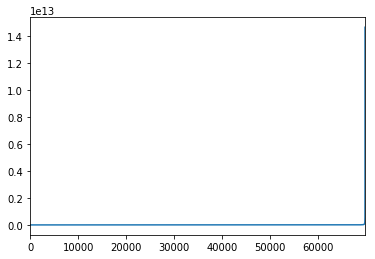

In [34]:
df.AMT_KRW.sort_values().reset_index(drop=True).plot()

In [126]:
df.columns = ['byr', 'spl', 'krw']

In [127]:
b = df['byr'].value_counts() >= 5
b = b[b].index.tolist()

In [128]:
s = df['spl'].value_counts() >= 5
s = s[s].index.tolist()

In [129]:
df = df.loc[(df['byr'].isin(b)) & (df['spl'].isin(s))].reset_index(drop=True)

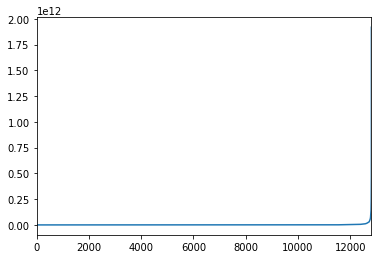

In [40]:
df.krw.sort_values().reset_index(drop=True).plot()

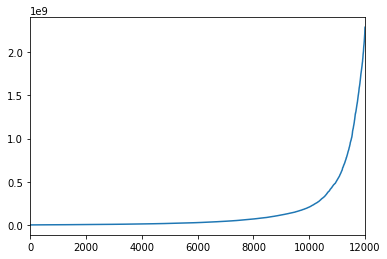

In [41]:
df.krw.sort_values().reset_index(drop=True).loc[:12000].plot()

In [42]:
df.groupby('krw').agg('size').sum()

12805

In [44]:
df.krw.min()

1967.0

In [58]:
df.groupby('krw').agg('size').cumsum()

krw
1.967000e+03        1
2.059600e+03        2
5.146428e+03        3
6.052000e+03        4
9.578800e+03        5
1.166000e+04        6
2.425800e+04        7
2.630200e+04        8
2.800000e+04        9
2.880600e+04       10
4.254480e+04       11
4.310460e+04       12
7.414240e+04       13
7.775600e+04       14
8.397000e+04       15
9.120000e+04       16
1.004000e+05       17
1.121590e+05       18
1.244000e+05       20
1.271866e+05       21
1.298610e+05       22
1.300000e+05       23
1.307540e+05       24
1.313664e+05       25
1.368400e+05       26
1.408000e+05       27
1.430600e+05       28
1.440000e+05       29
1.499750e+05       30
1.553134e+05       31
                ...  
8.035397e+10    12776
8.249502e+10    12777
8.950739e+10    12778
8.990397e+10    12779
9.085075e+10    12780
9.347234e+10    12781
9.510733e+10    12782
9.521663e+10    12783
1.034194e+11    12784
1.091901e+11    12785
1.114057e+11    12786
1.250185e+11    12787
1.354276e+11    12788
1.382505e+11    12789
1.4053

In [130]:
df.groupby('krw').agg('size').sum()

12805

In [131]:
rating_rate = {1: 0.17, 2: 0.32, 3: 0.45, 4: 0.56, 5: 0.66,
               6: 0.76, 7: 0.85, 8: 0.92, 9: 0.97, 10: 1}

In [134]:
rating = dict()
prev = 0
cumsum_df = df.groupby('krw').agg('size').cumsum()
total_sum = df.groupby('krw').agg('size').sum()
for i in rating_rate:
    val = cumsum_df.loc[cumsum_df >= rating_rate[i]*total_sum].index[0]
    rating[i] = [prev+1, val]
    prev = val

In [137]:
rating

{1: [1, 4513700.0],
 2: [4513701.0, 11880000.0],
 3: [11880001.0, 24175800.0],
 4: [24175801.0, 45876160.0],
 5: [45876161.0, 85246130.0],
 6: [85246131.0, 172672001.0],
 7: [172672002.0, 467034298.0],
 8: [467034299.0, 1548317232.0],
 9: [1548317233.0, 6363744200.0],
 10: [6363744201.0, 1918964615281.2]}

In [138]:
for i in rating:
    df.loc[(df.krw >= rating[i][0]) & (df.krw <= rating[i][1]), 'krw'] = i

In [139]:
df.head()

,byr,spl,krw
0,(유)브이피에이치아이,(주)오토탑,5.0
1,(유)브이피에이치아이,(주)평화발레오,10.0
2,(유)브이피에이치아이,(주)홍성브레이크,2.0
3,(유)브이피에이치아이,케이비와이퍼시스템 주식회사,4.0
4,(유)신한,강남제비스코(주),4.0


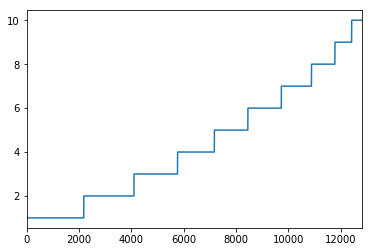

In [141]:
df.sort_values('krw').krw.reset_index(drop=True).plot()

In [142]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df, reader)

In [143]:
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,fit_time,test_rmse,test_time
Algorithm,,,
SVDpp,1.832927,2.058933,0.097882
SVD,0.346679,2.075707,0.021921
BaselineOnly,0.011228,2.134080,0.013395
KNNBaseline,0.108329,2.277622,0.055182
CoClustering,0.381328,2.309375,0.015639
KNNWithMeans,0.122305,2.317590,0.052226
KNNWithZScore,0.174571,2.331998,0.051632
NMF,0.655587,2.395998,0.019446
SlopeOne,0.083887,2.403409,0.057832


In [144]:
%%time
algo = surprise.SVDpp(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

CPU times: user 32.5 s, sys: 0 ns, total: 32.5 s
Wall time: 32.5 s


1.7134256662160936

In [145]:
%%time
algo = surprise.SVD(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.52 s


1.7037626912988493

In [150]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=0.25)
algo = surprise.SVDpp(n_factors=100)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 2.0978


2.097815565383235

In [151]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

rcm_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
rcm_df['Iu'] = rcm_df.uid.apply(get_Iu)
rcm_df['Ui'] = rcm_df.iid.apply(get_Ui)
rcm_df['err'] = abs(rcm_df.est - rcm_df.rui)

In [152]:
rcm_df.sort_values(by='err').head(10)

,uid,iid,rui,est,details,Iu,Ui,err
3200,광진섬유,(주)태흥통상,4.0,4.000075,{'was_impossible': False},1,5,0.000075
1341,(주)홍인상사,(주)현승아이앤씨,4.0,4.000403,{'was_impossible': False},6,2,0.000403
1818,(주)제이제이텍스타일,아씨텍스타일,3.0,3.000418,{'was_impossible': False},10,2,0.000418
903,신라커머스,(주) 오뚜기,3.0,3.000934,{'was_impossible': False},5,4,0.000934
152,주식회사 지티툴링,상원정밀,4.0,4.001756,{'was_impossible': False},1,2,0.001756
2671,(주)대관,(주)오뚜기,4.0,3.996489,{'was_impossible': False},6,24,0.003511
1482,(주)민성텍스타일,(주)야긴코퍼레이션,3.0,3.003677,{'was_impossible': False},3,23,0.003677
2997,(주)하티켐,(주)대운,4.0,3.995558,{'was_impossible': False},1,3,0.004442
2970,에이치비코퍼레이션(주),웅진식품(주),3.0,2.995144,{'was_impossible': False},19,10,0.004856
3193,(주)제이텍스,대영산업,5.0,4.994145,{'was_impossible': False},5,4,0.005855


In [153]:
rcm_df.sort_values(by='err').tail(10)

,uid,iid,rui,est,details,Iu,Ui,err
2102,세종공업(주),(주)청우,9.0,3.334898,{'was_impossible': False},4,4,5.665102
2231,기아자동차,(주)서연인테크,1.0,6.691708,{'was_impossible': False},141,4,5.691708
1991,(주)아이마켓코리아,(주)창남아이엔티,1.0,6.951792,{'was_impossible': False},31,12,5.951792
2277,(주)메트스틸,(주)대경벤드,10.0,3.970647,{'was_impossible': False},4,8,6.029353
557,(주)코텍,(주)케이디피,10.0,3.821611,{'was_impossible': False},10,2,6.178389
1743,현대자동차,한국알프스(주),3.0,9.405489,{'was_impossible': False},141,5,6.405489
1651,HYUNDAI MOBIS,동해금속 주식회사,1.0,7.543938,{'was_impossible': False},21,3,6.543938
833,현대위아(주),(주)센트랄모텍,1.0,8.257080,{'was_impossible': False},72,5,7.257080
1536,기아자동차,(주)신영,1.0,8.665785,{'was_impossible': False},141,2,7.665785
988,현대자동차,엘지전자(주),1.0,9.693306,{'was_impossible': False},141,6,8.693306


In [159]:
df.loc[(df.byr == '기아자동차') & (df.spl == '(주)서연인테크')]

,byr,spl,krw
5966,기아자동차,(주)서연인테크,1.0
